In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os

os.environ['HF_HOME'] = 'E:/Models/hf_cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = 'E:/Models/hf_cache'

In [3]:
# Install transformer-lens if not already installed
# !pip install transformer_lens
import warnings
warnings.filterwarnings('ignore')

from transformer_lens import HookedTransformer
import torch

torch.cuda.empty_cache()

# Load the model
model = HookedTransformer.from_pretrained(
        "google/gemma-2b-it",
        torch_dtype=torch.bfloat16,
        device="cuda",
        fold_ln=False,
        fold_value_biases=False,
        center_writing_weights=False,
        center_unembed=False,
    )
model.eval()

# Enable caching of all layer activations
model.set_use_split_qkv_input(True)  # (optional, recommended for interpretability)

print(model)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2b-it into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-17): 18 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): 

In [4]:
from transformer_lens.utils import get_tokenizer_with_bos

clean_prompt = "John found that the average of 15 numbers is 40. If 10 is added to each number then the mean of the numbers is? A) 50 B) 45 C) 65 D) 78 E) 64\nAnswer:"

buggy_prompt = "In the coordinate plane, points (x, 1) and (5, y) are on line k. If line k passes through the origin and has slope 1/5, then what are the values of x and y respectively? A) 4 and 1 B) 1 and 5 C) 5 and 1 D) 3 and 5 E) 5 and 3\nAnswer:"

# Get logits from the model
logits_clean = model(clean_prompt, return_type="logits")
logits_buggy = model(buggy_prompt, return_type="logits")

# Get final token logits (what comes after "Answer:")
final_logits_clean = logits_clean[0, -1]
print(final_logits_clean.shape)
final_logits_buggy = logits_buggy[0, -1]
print(final_logits_buggy.shape)

# Define answer options
answer_choices = ["A", "B", "C", "D", "E"]
answer_token_ids = [model.to_single_token(choice) for choice in answer_choices]
print(answer_token_ids)

# Filter logits for just the answer choices
answer_logits_clean = final_logits_clean[answer_token_ids]
print(answer_logits_clean)
answer_logits_buggy = final_logits_buggy[answer_token_ids]
print(answer_logits_buggy)

# Get predicted index (which option had the highest logit)
pred_index_clean = torch.argmax(answer_logits_clean).item()
print(pred_index_clean)
pred_index_buggy = torch.argmax(answer_logits_buggy).item()
print(pred_index_buggy)

# Map to letter
pred_answer_clean = answer_choices[pred_index_clean]
pred_answer_buggy = answer_choices[pred_index_buggy]

print("Predicted answer (clean):", pred_answer_clean)
print("Predicted answer (buggy):", pred_answer_buggy)

torch.Size([256000])
torch.Size([256000])
[235280, 235305, 235288, 235299, 235291]
tensor([8.5000, 7.2188, 7.0312, 6.1562, 3.6406], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<IndexBackward0>)
tensor([ 5.8125,  4.6875,  1.5312,  2.4219, -4.5938], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<IndexBackward0>)
0
0
Predicted answer (clean): A
Predicted answer (buggy): A


In [5]:
top_vals, top_idxs = torch.topk(final_logits_clean, k=5)

for val, idx in zip(top_vals, top_idxs):
    print(idx.item(), val.item(), "->", model.to_string([idx.item()]))

586 12.8125 ->  A
599 12.25 ->  B
585 11.8125 ->  C
608 11.3125 ->  D
12910 10.9375 ->  Option


In [6]:
top_vals, top_idxs = torch.topk(final_logits_buggy, k=5)

for val, idx in zip(top_vals, top_idxs):
    print(idx.item(), val.item(), "->", model.to_string([idx.item()]))

586 13.1875 ->  A
599 11.9375 ->  B
608 9.1875 ->  D
585 8.6875 ->  C
12910 8.25 ->  Option


In [7]:
import torch.nn.functional as F

c_token = model.to_single_token("C")
c_logit = final_logits_buggy[c_token].item()
probs = F.softmax(final_logits_buggy.float(), dim=-1)
c_prob = probs[c_token].item()

# rank of C among all tokens (1=head of list)
rank = torch.sum(final_logits_buggy > final_logits_buggy[c_token]).item() + 1

print(f"C token id = {c_token}")
print(f"C logit = {c_logit:.4f}, prob = {c_prob:.6f}, global rank = {rank}")

C token id = 235288
C logit = 1.5312, prob = 0.000007, global rank = 20


In [8]:
top_vals, top_idxs = torch.topk(final_logits_buggy, k=20)
for v,i in zip(top_vals, top_idxs):
    print(i.item(), f"{v.item():.3f}", "->", model.to_string([i.item()]))

586 13.188 ->  A
599 11.938 ->  B
608 9.188 ->  D
585 8.688 ->  C
12910 8.250 ->  Option
235248 7.188 ->  
5231 6.094 ->  **
235280 5.812 -> A
591 5.531 ->  (
235305 4.688 -> B
714 4.531 ->  The
109 3.953 -> 


139 3.891 ->   
108 3.891 -> 

4984 2.984 ->  option
11500 2.891 ->  Solution
10358 2.812 ->  Answer
637 2.562 ->  E
235299 2.422 -> D
235288 1.531 -> C


In [9]:
# Tokenize the clean prompt
clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
buggy_tokens = model.to_tokens(buggy_prompt, prepend_bos=True)

# Run the clean prompt and cache activations
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
buggy_logits, buggy_cache = model.run_with_cache(buggy_tokens)

# Confirm predicted answer
final_clean_logits = clean_logits[0, -1]
answer_logits_clean = final_clean_logits[answer_token_ids]
pred_index_clean = torch.argmax(answer_logits_clean).item()
print("Cached clean prediction:", answer_choices[pred_index_clean])

Cached clean prediction: A


In [10]:
list(clean_cache.keys())[:80]  # print first ~80 keys to inspect

['hook_embed',
 'blocks.0.hook_resid_pre',
 'blocks.0.hook_q_input',
 'blocks.0.hook_k_input',
 'blocks.0.hook_v_input',
 'blocks.0.ln1.hook_scale',
 'blocks.0.ln1.hook_normalized',
 'blocks.0.attn.hook_q',
 'blocks.0.attn.hook_k',
 'blocks.0.attn.hook_v',
 'blocks.0.attn.hook_rot_q',
 'blocks.0.attn.hook_rot_k',
 'blocks.0.attn.hook_attn_scores',
 'blocks.0.attn.hook_pattern',
 'blocks.0.attn.hook_z',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_resid_mid',
 'blocks.0.ln2.hook_scale',
 'blocks.0.ln2.hook_normalized',
 'blocks.0.mlp.hook_pre',
 'blocks.0.mlp.hook_pre_linear',
 'blocks.0.mlp.hook_post',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_pre',
 'blocks.1.hook_q_input',
 'blocks.1.hook_k_input',
 'blocks.1.hook_v_input',
 'blocks.1.ln1.hook_scale',
 'blocks.1.ln1.hook_normalized',
 'blocks.1.attn.hook_q',
 'blocks.1.attn.hook_k',
 'blocks.1.attn.hook_v',
 'blocks.1.attn.hook_rot_q',
 'blocks.1.attn.hook_rot_k',
 'blocks.1.attn.hook_attn_scores',
 '

In [11]:
from math import isnan

target_choice = 'C'
target_id = model.to_single_token(target_choice)

W_U = model.W_U  # shape (vocab_size, d_model)

def resid_post_for_layer(cache, layer):
    return cache[f"blocks.{layer}.hook_resid_post"][0, -1].detach()  # shape: (d_model,)

# compute logits after each layer for clean and buggy
n_layers = model.cfg.n_layers
clean_logits_by_layer = []
buggy_logits_by_layer = []

# initial residual (before any blocks) — depends on cache key naming
# try 'hook_embed' or 'hook_resid_pre' at layer 0
if "hook_embed" in clean_cache:
    resid0_clean = clean_cache["hook_embed"][0, -1].detach()
    resid0_buggy = buggy_cache["hook_embed"][0, -1].detach()
else:
    # fallback: resid_pre of layer 0
    resid0_clean = clean_cache["blocks.0.hook_resid_pre"][0, -1].detach()
    resid0_buggy = buggy_cache["blocks.0.hook_resid_pre"][0, -1].detach()

prev_clean = resid0_clean
prev_buggy = resid0_buggy

for i in range(n_layers):
    rp_clean = resid_post_for_layer(clean_cache, i)
    rp_buggy = resid_post_for_layer(buggy_cache, i)

    # logits vector after this layer
    logits_clean_i = (rp_clean @ W_U).detach().cpu()    # shape [vocab]
    logits_buggy_i = (rp_buggy @ W_U).detach().cpu()

    clean_logits_by_layer.append(logits_clean_i)
    buggy_logits_by_layer.append(logits_buggy_i)

import numpy as np 
clean_logits_by_layer = np.stack([t.float().cpu().numpy() for t in clean_logits_by_layer])
buggy_logits_by_layer = np.stack([t.float().cpu().numpy() for t in buggy_logits_by_layer])

In [12]:
# token ids of interest
A_id = model.to_single_token("A")
C_id = model.to_single_token("C")

# per-layer logit for token
clean_C = clean_logits_by_layer[:, C_id]   # shape (n_layers,)
buggy_C = buggy_logits_by_layer[:, C_id]

clean_A = clean_logits_by_layer[:, A_id]
buggy_A = buggy_logits_by_layer[:, A_id]

# compute incremental change across layers (delta from previous layer)
clean_C_delta = np.concatenate([[clean_C[0] - (prev_clean @ W_U).detach().float().cpu().numpy()[C_id]], np.diff(clean_C)])
buggy_C_delta = np.concatenate([[buggy_C[0] - (prev_buggy @ W_U).detach().float().cpu().numpy()[C_id]], np.diff(buggy_C)])
# simpler: just show logits by layer

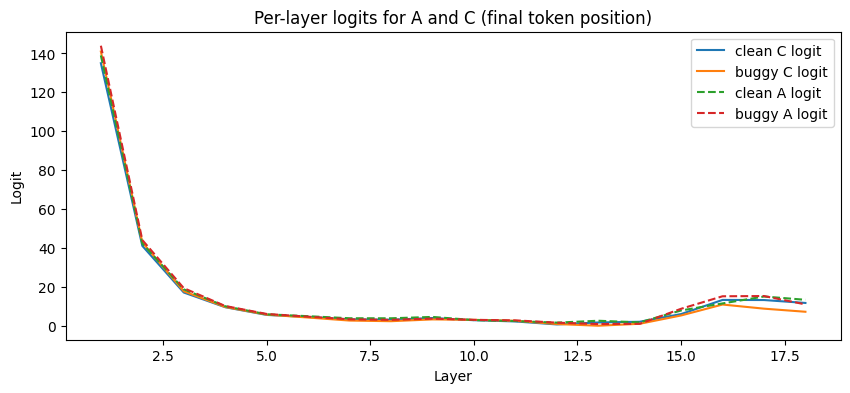

In [13]:
import matplotlib.pyplot as plt
layers = np.arange(1, n_layers+1)
plt.figure(figsize=(10,4))
plt.plot(layers, clean_C, label="clean C logit")
plt.plot(layers, buggy_C, label="buggy C logit")
plt.plot(layers, clean_A, '--', label="clean A logit")
plt.plot(layers, buggy_A, '--', label="buggy A logit")
plt.xlabel("Layer")
plt.ylabel("Logit")
plt.legend()
plt.title("Per-layer logits for A and C (final token position)")
plt.show()

In [14]:
import torch.nn.functional as F

# Robust similarity helpers (flatten to 1-D vectors first)
def l2(a, b):
    a, b = a.detach(), b.detach()
    return float(torch.norm(a.reshape(-1) - b.reshape(-1)).cpu().item())

def cos_sim(a, b):
    a, b = a.detach().reshape(-1), b.detach().reshape(-1)
    # handle zero vectors gracefully
    if torch.all(a == 0) or torch.all(b == 0):
        return float(0.0)
    return float(F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).cpu().item())

mlp_diffs = []
attn_diffs = []

n_layers = model.cfg.n_layers

for layer in range(n_layers):
    # MLP post-activation
    mlp_key = f"blocks.{layer}.mlp.hook_post"
    if mlp_key in clean_cache and mlp_key in buggy_cache:
        a = clean_cache[mlp_key][0, -1]   # final token position
        b = buggy_cache[mlp_key][0, -1]
        try:
            mlp_diffs.append((layer, l2(a, b), cos_sim(a, b)))
        except Exception as e:
            mlp_diffs.append((layer, float('nan'), float('nan')))
            print(f"MLP layer {layer} error computing sims: {e}")

    # Attention output (hook_z) — may have shape [seq, heads, d_head] or [seq, d_model]
    attn_key = f"blocks.{layer}.attn.hook_z"
    if attn_key in clean_cache and attn_key in buggy_cache:
        a = clean_cache[attn_key][0, -1]
        b = buggy_cache[attn_key][0, -1]
        # If per-head (e.g., shape [heads, d_head]) we may want a per-head summary,
        # but here we compute a single scalar per-layer by flattening.
        try:
            attn_diffs.append((layer, l2(a, b), cos_sim(a, b)))
        except Exception as e:
            attn_diffs.append((layer, float('nan'), float('nan')))
            print(f"ATTN layer {layer} error computing sims: {e}")

# Show top differing layers (MLP and ATTN)
mlp_diffs_sorted = sorted(mlp_diffs, key=lambda x: x[1] if not torch.isnan(torch.tensor(x[1])) else -float('inf'), reverse=True)
attn_diffs_sorted = sorted(attn_diffs, key=lambda x: x[1] if not torch.isnan(torch.tensor(x[1])) else -float('inf'), reverse=True)

print("Top MLP L2 diffs (layer, L2, cos):")
for item in mlp_diffs_sorted[:10]:
    print(item)

print("\nTop ATTN L2 diffs (layer, L2, cos):")
for item in attn_diffs_sorted[:10]:
    print(item)

Top MLP L2 diffs (layer, L2, cos):
(16, 37.75, 0.76171875)
(15, 36.0, 0.75390625)
(14, 32.25, 0.77734375)
(13, 31.75, 0.7890625)
(17, 26.75, 0.78515625)
(12, 24.125, 0.8359375)
(11, 16.0, 0.91015625)
(10, 12.9375, 0.8984375)
(0, 12.125, 0.9921875)
(8, 9.6875, 0.8828125)

Top ATTN L2 diffs (layer, L2, cos):
(16, 21.875, 0.484375)
(12, 21.0, 0.64453125)
(15, 15.875, 0.80859375)
(14, 14.75, 0.80859375)
(0, 12.75, 0.984375)
(13, 11.625, 0.78125)
(17, 11.1875, 0.80859375)
(11, 9.4375, 0.76953125)
(10, 8.75, 0.80078125)
(8, 7.125, 0.87890625)


In [27]:
import circuitsvis as cv

for layer in range(n_layers):
    print(type(clean_cache))
    attention_pattern = clean_cache["pattern", layer]
    print(attention_pattern.shape)
    clean_tokens = model.to_str_tokens(clean_prompt)

    print(f"Layer {layer} Head Attention Patterns:")
    display(
        cv.attention.attention_heads(
            tokens=clean_tokens,
            attention=attention_pattern,
            attention_head_names=[f"L{layer}H{i}" for i in range(12)],
        )
    )

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 0 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 1 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 2 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 3 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 4 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 5 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 6 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 7 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 8 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 9 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 10 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 11 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 12 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 13 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 14 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 15 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 16 Head Attention Patterns:


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([1, 8, 61, 61])
Layer 17 Head Attention Patterns:


In [6]:
def get_patch_hook(component_name, layer, head_idx=None):
    if component_name == "attn":
        name = f"blocks.{layer}.attn.hook_z"
        def hook_fn(buggy_act, hook):
            clean_act = clean_cache[name]  # shape: [1, seq, heads, d_head]
            return buggy_act.clone().detach().copy_(clean_act)
        return [(name, hook_fn)]
    elif component_name == "mlp":
        name = f"blocks.{layer}.mlp.hook_post"
        def hook_fn(buggy_act, hook):
            clean_act = clean_cache[name]
            return buggy_act.clone().detach().copy_(clean_act)
        return [(name, hook_fn)]
    else:
        raise ValueError("Unsupported component")

In [7]:
clean_tokens = model.to_tokens(clean_prompt, prepend_bos=True)
buggy_tokens = model.to_tokens(buggy_prompt, prepend_bos=True)

min_len = min(clean_tokens.shape[1], buggy_tokens.shape[1])
clean_tokens = clean_tokens[:, :min_len]
buggy_tokens = buggy_tokens[:, :min_len]

patched_results = []

for layer in range(model.cfg.n_layers):
    # Patch each attention layer
    attn_hooks = get_patch_hook("attn", layer)
    attn_logits = model.run_with_hooks(buggy_tokens, return_type = "logits", fwd_hooks=attn_hooks)
    attn_final = attn_logits[0, -1]
    attn_ans_logits = attn_final[answer_token_ids]
    attn_ans = torch.argmax(attn_ans_logits).item()
    patched_results.append(("attn", layer, answer_choices[attn_ans]))

    # Patch MLP layer
    mlp_hooks = get_patch_hook("mlp", layer)
    mlp_logits = model.run_with_hooks(buggy_tokens, return_type = "logits", fwd_hooks=mlp_hooks)
    mlp_final = mlp_logits[0, -1]
    mlp_ans_logits = mlp_final[answer_token_ids]
    mlp_ans = torch.argmax(mlp_ans_logits).item()
    patched_results.append(("mlp", layer, answer_choices[mlp_ans]))

In [ ]:
# Unpatched buggy answer (again)
final_logits_buggy = logits_buggy[0, -1]
unpatched_logits = final_logits_buggy[answer_token_ids]
unpatched_ans = torch.argmax(unpatched_logits).item()
print("Unpatched buggy answer:", answer_choices[unpatched_ans])

# Report flipped predictions
print("\nComponents that flipped the answer:")
for comp_type, layer, pred in patched_results:
    if pred != answer_choices[unpatched_ans]:
        print(f"{comp_type.upper()} layer {layer} → predicted {pred}")


Unpatched buggy answer: A

Components that flipped the answer:
MLP layer 0 → predicted B
MLP layer 4 → predicted B
MLP layer 5 → predicted B
ATTN layer 7 → predicted B
MLP layer 7 → predicted B
MLP layer 13 → predicted B
MLP layer 15 → predicted D
MLP layer 17 → predicted B


In [9]:
correct_answer = "C"
correct_index = answer_choices.index(correct_answer)

if unpatched_ans == correct_index:
    print("Model got it right (C).")
else:
    print(f"Model was wrong. It predicted {answer_choices[unpatched_ans]}, but correct is {correct_answer}.")

Model was wrong. It predicted A, but correct is C.


In [10]:
print("\nComponents that predicted the correct answer (C):")

correct_index = answer_choices.index(correct_answer)

for comp_type, layer, pred in patched_results:
    if pred == correct_index:
        print(f"{comp_type.upper()} layer {layer} → predicted C ✅")


Components that predicted the correct answer (C):
